#**1-Configurando el ambiente**

In [26]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import numpy as pd
import matplotlib.pyplot  as plt

In [27]:
global tendencia, precio_actual, df_bitcoin, media_bitcoin, algoritmo_decision, variacion, precio

In [3]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 2.0.3
------
Name: numpy
Version: 1.25.2
------
Name: matplotlib
Version: 3.7.1


#**2-Obtención de los datos**

In [28]:
def importar_base_bitcoin():
  global tendencias, precio_actual, df_bitcoin, media_bitcoin, algoritmo_decision, variacion, precio
  df_bitcoin = yf.download('BTC-USD', interval= '5m', period= '7d')
importar_base_bitcoin()

[*********************100%%**********************]  1 of 1 completed


In [15]:
df_bitcoin

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-04-23 00:00:00+00:00,66845.789062,66853.726562,66816.921875,66816.921875,66816.921875,0
2024-04-23 00:05:00+00:00,66811.804688,66837.960938,66793.546875,66837.960938,66837.960938,31557632
2024-04-23 00:10:00+00:00,66874.296875,66878.773438,66862.296875,66867.921875,66867.921875,5736448
2024-04-23 00:15:00+00:00,66863.515625,66869.367188,66834.765625,66834.765625,66834.765625,29747200
2024-04-23 00:20:00+00:00,66793.617188,66863.765625,66793.617188,66812.851562,66812.851562,0
...,...,...,...,...,...,...
2024-04-29 20:25:00+00:00,63037.902344,63037.902344,63017.437500,63017.437500,63017.437500,12058624
2024-04-29 20:30:00+00:00,62998.906250,63031.222656,62996.464844,63031.222656,63031.222656,8841216
2024-04-29 20:35:00+00:00,63020.035156,63042.472656,63020.035156,63042.472656,63042.472656,2297856


In [29]:
def extraer_tendencias():
  global tendencia, precio_actual, df_bitcoin, media_bitcoin, algoritmo_decision, variacion, precio

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'}
  url ='https://coinmarketcap.com/'

  #generando la respuesta para extraer el texto de la pagina
  respuesta = requests.get(url, headers=headers )
  s=BeautifulSoup(respuesta.content, 'lxml')

  #extrayendo los precios y la variacion de la pagina
  precio = s.find('a',{'href':'/currencies/bitcoin/#markets'}).getText()
  precio_actual = float(precio.replace('$', '').replace(',', ''))
  variacion = s.find('a',{'href':'/currencies/bitcoin/#markets'}).find_next('td')

  #verificando si la tendencia es alta o baja
  if 'icon-Caret-down' in str(variacion):
    tendencia = 'Baja'
  elif 'icon-Caret-up' in str(variacion):
    tendencia = 'Alta'
  variacion =variacion.getText()


#**3-Limpieza de los datos**

In [30]:


def limpieza_datos():
  global tendencia, precio_actual, df_bitcoin, media_bitcoin, algoritmo_decision, variacion, precio
  #hacemos una copia del dataframe original y colocamos el nombre a las columnas
  df_bitcoin_limpio = df_bitcoin.copy()
  df_bitcoin_limpio = df_bitcoin_limpio.reset_index()

  #detectar duplicados
  duplicado = df_bitcoin_limpio.duplicated(subset=['Datetime'])

  if duplicado.any() == True:
    df_bitcoin_limpio = df_bitcoin_limpio['Datetime'].drop_duplicates()

  #detectando valores nulos en la columna close
  close_nulos = df_bitcoin_limpio['Close'].isnull().any()

  if close_nulos.any() == True:
    df_bitcoin_limpio = df_bitcoin_limpio['Close'].bfill()

  #seleccionando valores mayores a 0 en la columna volume
  df_bitcoin_limpio =df_bitcoin_limpio[df_bitcoin_limpio['Volume']>0]

  # hacemos un boxplot para analizar los valores
  #plt.figure(figsize=(8,6))
  #plt.boxplot(df_bitcoin_limpio['Close']);

  #eliminando outliers en el precio de cierre
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

  #rango intercuartil
  IQR = Q3 - Q1

  #limite inferior y superior
  limite_inf = df_bitcoin_limpio['Close'] -1.5 * IQR
  limite_sup = df_bitcoin_limpio['Close'] + 1.5 *IQR

  #filtro para quedarme con los datos superiores e inferiores
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= limite_inf) & (df_bitcoin_limpio['Close'] <= limite_sup)]

  #seleccionar valores entre Q1 y Q3 y sacar el promedio
  seleccion = (df_bitcoin_limpio['Close'] >=Q1) & (df_bitcoin_limpio['Close'] <=Q3)
  media_bitcoin = df_bitcoin_limpio[seleccion]['Close'].mean()


#**4- Toma de decision**

In [31]:
def tomar_decisiones():
  global tendencia, precio_actual, df_bitcoin, media_bitcoin, algoritmo_decision, variacion, precio

  if (precio_actual >= media_bitcoin) and (tendencia == 'Baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) and (tendencia =='Alta'):
    algoritmo_decision ='Comprar'
  else:
    algoritmo_decision = 'Espera'


#**5-Visualizacion**

In [32]:
def visualizacion():
  global tendencia, precio_actual, df_bitcoin, media_bitcoin, algoritmo_decision, variacion, precio

  df_bitcoin['Promedio'] = media_bitcoin

  t = '\u25b4' if tendencia=='alta' else '\u25be'
  color = 'green' if tendencia=='alta' else 'red'

  x = df_bitcoin.index
  y1 = df_bitcoin['Close']
  y2 = df_bitcoin['Promedio']
  plt.figure(figsize=(16,5))
  plt.plot(x,y1, label = "Precio de cierre")
  plt.plot(x,y2, label = "Precio Promedio")
  plt.xlabel("Fecha")
  plt.ylabel("Precio BTC/USD")
  plt.legend()
  plt.annotate(algoritmo_decision,xy=(x[-5],y1.min()),bbox=dict(boxstyle="square", fc= "lightsteelblue"), size=15)
  plt.annotate("$%.2f" %media_bitcoin,xy=(x[-1],media_bitcoin),bbox=dict(boxstyle="square", fc= "coral"), size=10)
  plt.title("$\mathbf{Bitcoin}$"+" " +"$\mathbf{BTC}$\n", fontsize = "20", y=1.02, x=0.07)
  title = plt.title(f'{precio} ', fontsize = "25", loc= "left")
  plt.annotate(f'{t}{variacion}', fontsize = "20", color=color, xycoords=title, xy=(1, 0.2))
  plt.show()


#**6-Automatizacion**

In [33]:
#importando clear_output para borrar la pantalla cada vez que se ejecute el algoritmo
from IPython.display import clear_output

#importamos time para reinciar el algoritmo cada que pase el tiempo colocado
import time

En la grafica podemos observar lo siguente:
- el valor del bitcoin actual en negro
- la variacion en porcentaje del ultimo precio que puede ser rojo(bajó) o verde(subió)
- en linea azul graficada es el precio del bitoin
- linea naranja es el promedio del precio del bitoin
- en la equina inferior derecha la decision de comprar, esperar o vender dependiendo la respuesta

[*********************100%%**********************]  1 of 1 completed


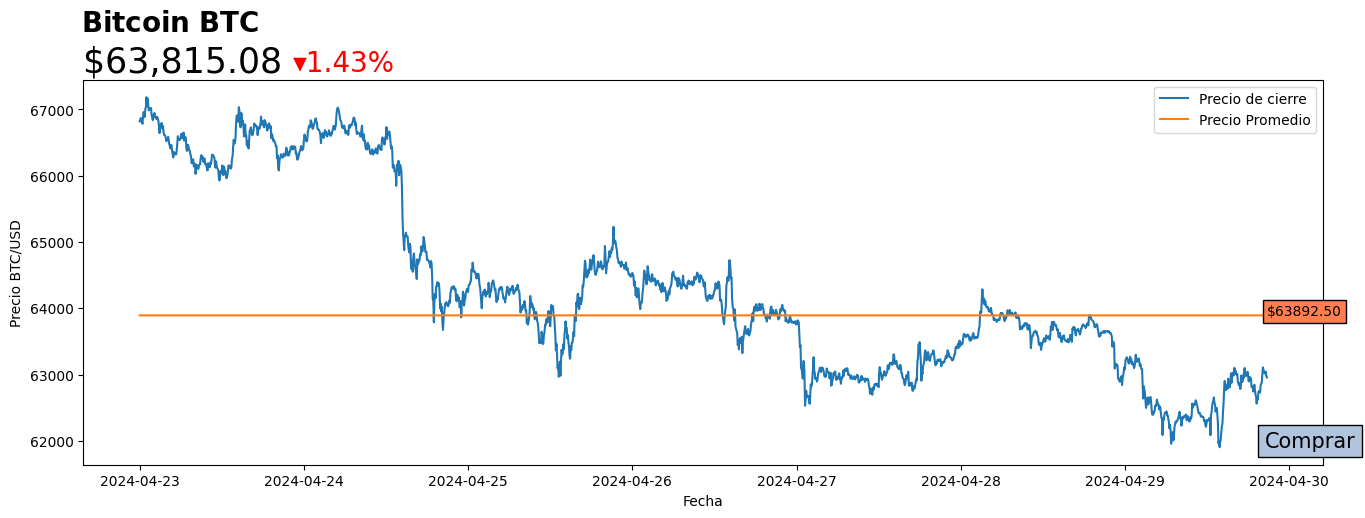

In [ ]:
#hacemos un loop infinito para que se ejecute

while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)
